# Numerical modeling workshop (Rijeka, 2022) — third day

## Source-sink experiment

### Preliminaries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from copy import copy, deepcopy

In [2]:
Deltax = Deltay = d = 250000 # spatial step and the least distance between two cells in the grid
Deltat = 600 # time step
g = 9.81 # gravitational constant
f = 10 ** (-4) # coriolis force constant
Lx = 23250000 # domain size in x direction
Ly = 21000000 # domain size in y direction
SSdistance = 1750000 # distance between source and sink
IM = round(Ly / Deltay) + 1 # number of grid points in y direction
JM = round(Lx / Deltax) + 1 # number of grid points in x direction
# NB: index i will correspond to y direction and index x will correspond to x direction
HN = 1000 # initial, unperturbed water height (over all domain)
T_steps = 10 # number of time steps
dh = round(2 * Deltat / 60) # water influx/outflux per time unit
Nmax = Deltat * T_steps # total time

In [3]:
def source_coordinates(lx, im, jm, deltax, ssdistance):
    j_left = round(((lx - ssdistance) / 2) / deltax)
    j_right = round(((lx - ssdistance) / 2) / deltax) + 1
    i_upper = round(im / 2)
    i_lower = round(im / 2) + 1
    return [i_upper, i_lower, j_left, j_right]
def sink_coordinates(lx, im, jm, deltax, ssdistance):
    j_left = round(((lx + ssdistance) / 2) / deltax)
    j_right = round(((lx + ssdistance) / 2) / deltax) + 1
    i_upper = round(im / 2)
    i_lower = round(im / 2) + 1
    return [i_upper, i_lower, j_left, j_right]

In [4]:
print(source_coordinates(Lx, IM, JM, Deltax, SSdistance))
print(sink_coordinates(Lx, IM, JM, Deltax, SSdistance))

[42, 43, 43, 44]
[42, 43, 50, 51]


In [5]:
# sink and source positioning in grid — we are given that the size of each is exactly 4 points
# and that their horizontal distance is 1750 km (while being centered as well)

i_source_upper, i_source_lower, j_source_left, j_source_right = source_coordinates(Lx, IM, JM, Deltax, SSdistance)
i_sink_upper, i_sink_lower, j_sink_left, j_sink_right = sink_coordinates(Lx, IM, JM, Deltax, SSdistance)

Type C grid:

    h  u  h  u  h  u  h
    
    v     v     v     v
    
    h  u  h  u  h  u  h
    
    v     v     v     v
    
    h  u  h  u  h  u  h

Starting from yesterday's shallow-water equations

\begin{equation}
\begin{aligned}
h_{i,j}^{n+1} &= h_{i,j}^n - \frac{H\Delta t}{d}\left[\left(u_{i,j}^n - u_{i-1,j}^n\right) + \left(v_{i,j}^n - v_{i,j-1}^n\right)\right]\,\text,\\
u_{i,j}^{n+1} &= u_{i,j}^n - \Delta t\left[\frac gd\left(h_{i+1,j}^{n+1} - h_{i,j}^{n+1}\right) + \frac f4\left(v_{i,j}^n+v_{i+1,j}^n+v_{i+1,j-1}^n+v_{i,j-1}^n)\right)\right]\,\text,\\
v_{i,j}^{n+1} &= v_{i,j}^n - \Delta t\left[\frac gd\left(h_{i,j+1}^{n+1}-h_{i,j}^{n+1}\right) - \frac f4\left(u_{i,j}^n + u_{i,j+1}^n + u_{i-1,j+1}^n + u_{i-1,j}^n\right)\right]\,\text,
\end{aligned}
\tag{$\vartriangle$}
\end{equation}

we endow them with advective terms:

\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= -g\frac{\partial h}{\partial x}
+fv\,\text,\\
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= -g\frac{\partial h}{\partial y} - fu\,\text,\\
\frac{\partial h}{\partial t}  + u\frac{\partial h}{\partial x} + v\frac{\partial h}{\partial y}  &= -H\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\right)\,\text.
\end{aligned}

Comment about grid: when discretizing using finite differences, it is necessary that averages fall exactly into desired positions. For example, in first of the previous three equation, there exists a term $v\frac{\partial u}{\partial y}$ and that particular $v$ enters as average because its value is not defined at precise position of $u$ in the grid ($u$'s value is evidently defined so it enters the first equation directly). Analogously, in the second equation $v$ enters directly, while $u$ is averaged:

\begin{aligned}
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = u\overline{\delta_xu}^x + \bar{v}^{xy}\overline{\delta_yu}^y\,\text,\\
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = \bar{u}^{xy} \overline{\delta_xv}^x + v\overline{\delta_yv}^y\,\text,\\
u\frac{\partial h}{\partial x} + v\frac{\partial h}{\partial y} = \bar{u}^x\overline{\delta_xh}^x + \bar{v}^y\overline{\delta_yh}^y\,\text.
\end{aligned}

Indexed terms to be added on RHSs of equations in ($\vartriangle$) are (in order):

\begin{aligned}
-\Delta t\left[u_{i,j}^n \cdot\frac12\left(\frac{u_{i+1,j}^n - u_{i,j}^n}d + \frac{u_{i,j}^n-u_{i-1,j}^n}d\right) + \frac14\left(v_{i,j}^n + v_{i+1,j}^n + v_{i,j-1}^n + v_{i+1,j-1}^n \right) \frac12\left(\frac{u_{i,j+1}^n - u_{i,j}^n}d + \frac{u_{i,j}^n - u_{i,j-1}^n}d\right)\right]\,\text,\\
-\Delta t\left[\frac14\left(u_{i,j}^n + u_{i,j+1}^n + u_{i-1,j+1}^n + u_{i-1,j}^n \right) \frac12\left(\frac{v_{i+1,j}^n - v_{i,j}^n}d + \frac{v_{i,j}^n - v_{i-1,j}^n}d\right) + v_{i,j}^n \cdot\frac12\left(\frac{v_{i,j+1}^n - v_{i,j}^n}d + \frac{v_{i,j}^n-v_{i,j-1}^n}d\right)\right]\,\text,\\
-\Delta t\left[\left(\frac{u_{i,j}^n+u_{i-1,j}^n}{2}\right)\frac12\left(\frac{h_{i+1,j}^n-h_{i,j}^n}d + \frac{h_{i,j}^n - h_{i-1,j}^n}d\right) + \left(\frac{v_{i,j}^n+v_{i,j-1}^n}{2}\right)\frac12\left(\frac{h_{i,j+1}^n-h_{i,j}^n}d + \frac{h_{i,j}^n - h_{i,j-1}^n}d\right)\right]\,\text.
\end{aligned}

After cancellations and grouping:

\begin{aligned}
-&\frac{\Delta t}2\left[u_{i,j}^n\left(\frac{u_{i+1,j}^n - u_{i-1,j}^n}d \right) + \frac14\left(v_{i,j}^n + v_{i+1,j}^n + v_{i,j-1}^n + v_{i+1,j-1}^n \right) \left(\frac{u_{i,j+1}^n - u_{i,j-1}^n}d\right)\right]\,,\\
-&\frac{\Delta t}2\left[\frac14\left(u_{i,j}^n + u_{i,j+1}^n  + u_{i-1,j}^n+ u_{i-1,j+1}^n \right) \left(\frac{v_{i+1,j}^n - v_{i-1,j}^n}d\right) + v_{i,j}^n \left(\frac{v_{i,j+1}^n - v_{i,j-1}^n}d\right)\right]\,,\\
-&\frac{\Delta t}4\left[\left(u_{i,j}^n+u_{i-1,j}^n\right)\left(\frac{h_{i+1,j}^n-h_{i-1,j}^n}d \right) + \left(v_{i,j}^n+v_{i,j-1}^n\right)\left(\frac{h_{i,j+1}^n-h_{i,j-1}^n}d \right)\right]\,\text.
\end{aligned}

In [6]:
# initialization of variables
U = np.zeros((IM, JM), dtype=float)
V = np.zeros((IM, JM), dtype=float)
H = np.full((IM, JM), HN, dtype=float)
UF = np.zeros((IM, JM), dtype=float)
VF = np.zeros((IM, JM), dtype=float)
HF = np.full((IM, JM), HN, dtype=float)

n =  0


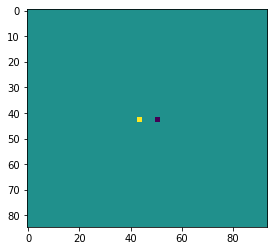

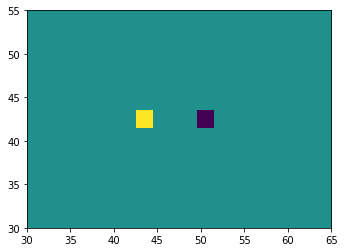

n =  50


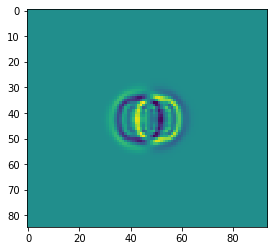

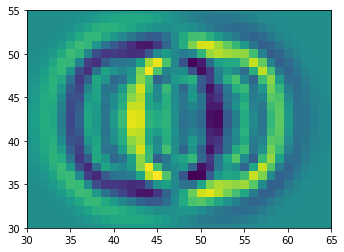

n =  100


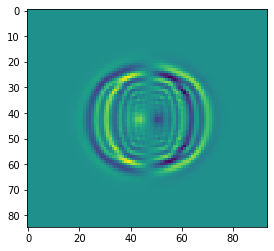

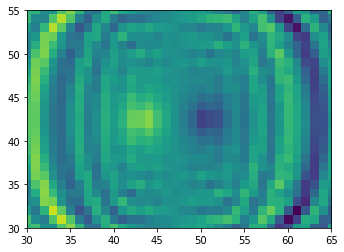

n =  150


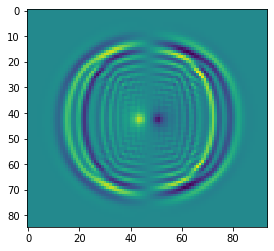

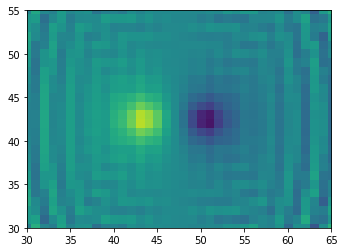

n =  200


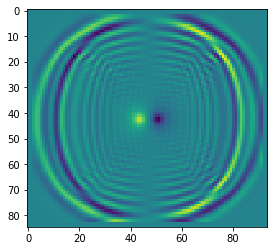

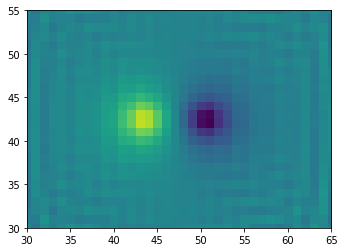

n =  250


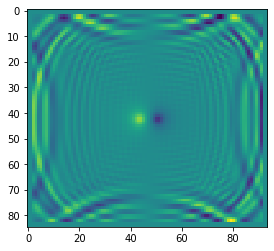

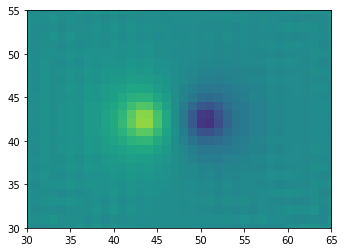

n =  300


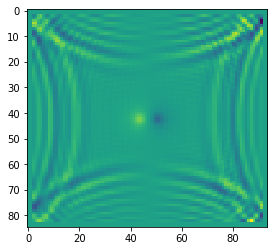

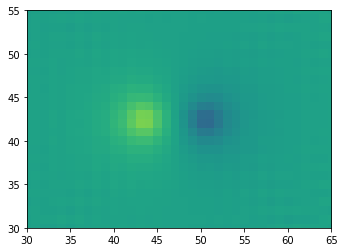

Wall time: 3min 1s


In [7]:
%%time
for n in range(Nmax):
    for i in range(2, IM - 2):
        for j in range(2, JM - 2):
            # discretized differential equations (including advection)
            UF_cor = -(Deltat / 2) *\
              (U[i, j] * (U[i - 1, j] - U[i + 1, j]) / d + (1 / 4) *\
              (V[i, j] + V[i - 1, j] + V[i, j + 1] + V[i - 1, j + 1]) * ((U[i, j - 1] - U[i, j + 1]) / d))
            VF_cor = -(Deltat / 2) *\
              ((1 / 4) *\
              (U[i, j] + U[i, j - 1] + U[i + 1, j] + U[i + 1, j - 1]) * ((V[i - 1, j] - V[i + 1, j]) / d)\
              + V[i, j] * (V[i, j - 1] - V[i, j + 1]) / d) 
            HF_cor = -(Deltat / 4) *\
            ((U[i, j] + U[i + 1, j]) * ((H[i - 1, j] - H[i + 1, j]) / d) +\
             (V[i, j] + V[i, j + 1]) * ((H[i, j - 1] - H[i, j + 1]) / d))
                        
            HF[i, j] = H[i, j] -\
              (HN * Deltat / d) * ((U[i, j] - U[i + 1, j]) + (V[i, j] - V[i, j + 1])) + HF_cor

            UF[i, j] = U[i, j] -\
              Deltat * ((g / d) *\
               (HF[i - 1, j] - HF[i, j]) + (f / 4) * (V[i, j] + V[i - 1, j] + V[i - 1, j + 1] + V[i, j + 1]))\
              + UF_cor

            VF[i, j] = V[i, j] -\
              Deltat * ((g / d) *\
               (HF[i, j - 1] - HF[i, j]) - (f / 4) * (U[i, j] + U[i, j - 1] + U[i + 1, j - 1] + U[i + 1, j]))\
              + VF_cor

            U = deepcopy(UF)
            V = deepcopy(VF)
            H = deepcopy(HF)
            
            if n < 10: # for stability, we let in/outflux only for a limited time
                # simulation of influx from source
                H[i_source_upper, j_source_left] += dh
                H[i_source_upper, j_source_right] += dh
                H[i_source_lower, j_source_left] += dh
                H[i_source_lower, j_source_right] += dh

                # simulation of outflux through sink
                H[i_sink_upper, j_sink_left] -= dh
                H[i_sink_upper, j_sink_right] -= dh
                H[i_sink_lower, j_sink_left] -= dh
                H[i_sink_lower, j_sink_right] -= dh
    if n % 50 == 0:
        print('n = ', n)
        plt.imshow(H, interpolation='none')
        plt.show()
        plt.xlim(30, 65)
        plt.ylim(30, 55)
        plt.imshow(H, interpolation='none')
        plt.show()
    if n == 300:
        break

TODO: comments on equations, long-time behaviour

TODO: why is the system in which we provide constant in/outflux less stable than this one?